In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import gradient
import astropy.constants as cn
import astropy.units as u
from scipy.integrate import simps
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import numpy as np
from scipy.signal import stft
from scipy.fftpack import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as font_manager

from matplotlib import cm
import re
import itertools
import scipy
from scipy import interpolate

from scipy.fftpack import fft
from scipy import signal
                                                                                                                                                                                                                      
from scipy.interpolate import interp1d                                                                                                      
import matplotlib
                                                                              
matplotlib.rcParams.update({'font.size': 21})                                                                                               
                                                                                                                                            
matplotlib.rcParams['xtick.direction'] = 'in'                                                                                               
matplotlib.rcParams['ytick.direction'] = 'in'                                                                                               
matplotlib.rcParams['xtick.top'] = True                                                                                                     
matplotlib.rcParams['ytick.right'] = True                                                                                                   
                                                                                                                                            
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'                                                                                           
matplotlib.rcParams.update({'pgf.rcfonts' : False})                                                                                         
                                                                                                                                            
matplotlib.rcParams['axes.linewidth'] = 2                                                                                                   
matplotlib.rcParams['xtick.major.size'] = 6                                                                                                
matplotlib.rcParams['xtick.major.width'] = 2                                                                                                
matplotlib.rcParams['xtick.minor.size'] = 4                                                                                                
matplotlib.rcParams['xtick.minor.width'] = 0.5                                                                                                
                                                                                                                                            
matplotlib.rcParams['ytick.major.size'] = 6                                                                                                
matplotlib.rcParams['ytick.major.width'] = 2                                                                                                
matplotlib.rcParams['ytick.minor.size'] = 4                                                                                                
matplotlib.rcParams['ytick.minor.width'] = 0.5

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5



Spectrograms must be done with some care, and you might need to change
how you normalise the plot. The window size, overlap, and shift also make
a big difference in the STFT.

In [12]:
def read_model(model_file,iskip=10):
    with open(model_file) as f_in:
        model = np.genfromtxt(itertools.islice(f_in, 0, None, iskip), dtype=float)
    return model

def clean_model(model_file,newFile = 'reduced.dat',nReduce = 10):
    fstream = open(newFile,'w')
    data = read_model(model_file,iskip=None)
    nlines = len(data)
    ncols = len(data[0])
    cleaned_data = np.zeros(nlines*ncols).reshape(nlines,ncols)
    time = 10000000000
    index_clean = 0
    for i in range(nlines):
        index = nlines-i-1
        if data[index][0] < time:
            cleaned_data[index_clean] = data[index]
            index_clean += 1
            time = data[index][0]

    trimmed_cleaned_data = np.zeros(index_clean*ncols).reshape(index_clean,ncols)
    for i in range(len(trimmed_cleaned_data)):
        trimmed_cleaned_data[i] = cleaned_data[index_clean-i-1]

    for i in range(0,len(trimmed_cleaned_data),nReduce):
        for col in range(ncols):
            fstream.write(str(trimmed_cleaned_data[i][col])+" ")
        fstream.write("\n")          
    fstream.close()
    

In [1]:
#The equations can be found in Andresen_17 and E.Muller+12; the last reference
#goes through the details but has a few minor typos in the equations
#t : theta, p : phi. 
#Note that this assumes 3D

def getQs(modl):
    #axx,ayy,azz,axy,axz,ayz
    return modl[:,45],modl[:,47],modl[:,50],modl[:,46],modl[:,48],modl[:,49]
    

def Qtp(axx,ayy,azz,axy,axz,ayz,t,p):
    ct = np.cos(t)
    st = np.sin(t)
    cp = np.cos(p)
    sp = np.sin(p)
    Qtp = (ayy-axx)*ct*sp*cp + axy*ct*(cp**2 - sp**2) + axz*st*sp - ayz*st*cp
    return Qtp

def Qpp(axx,ayy,azz,axy,axz,ayz,t,p):
    cp = np.cos(p)
    sp = np.sin(p)
    Qpp = axx*sp**2 + ayy*cp**2 - 2*axy*cp*sp
    return Qpp

def Qtt(axx,ayy,azz,axy,axz,ayz,t,p):
    ct = np.cos(t)
    st = np.sin(t)
    cp = np.cos(p)
    sp = np.sin(p)
    Qtt = (axx*cp**2 + ayy*sp**2 + 2*axy*sp*cp)*ct**2 + azz*st**2 - 2*(axy*cp+ayz*sp)*st*ct
    return Qtt

def Ap(axx,ayy,azz,axy,axz,ayz,t,p):
    Ap = Qtt(axx,ayy,azz,axy,axz,ayz,t,p) - Qpp(axx,ayy,azz,axy,axz,ayz,t,p)
    return Ap

def Ac(axx,ayy,azz,axy,axz,ayz,t,p):
    Ac = 2*Qtp(axx,ayy,azz,axy,axz,ayz,t,p)
    return Ac

In [120]:
#These are routines developed by Haakon; the spectrogram is implemented from scratch.

def spectrogram_full(t,h,shift_value=1e-4,window_length=25e-3):
    from scipy.fftpack import fft
    from scipy import signal
    N = 4*512
    nf = 2*N
    wdt = window_length
    dt = wdt/(nf)
    freq = np.fft.fftfreq(nf, d=dt)

    ffpeuq = interp1d(t, h)
    tshift = min(t)
    fnyq = max(freq)
    bl, al = signal.butter(2, 5000.0/fnyq,'low')
    bh, ah = signal.butter(2, 25.0/fnyq,'high')
    window = signal.kaiser(nf,2.5)
    window =  signal.blackman(nf)
    t2 = np.linspace(tshift,wdt+tshift,nf)
    tarr = []
    fttm = []
    j = 0
    while(max(t2) < max(t)):
        amp = ffpeuq(t2)
        amp1 = signal.filtfilt(bh, ah, amp)
        amp2 = signal.filtfilt(bl, al, amp1)
        amp3 = amp2*window
        fftamp  = (np.abs(fft(amp3))[0:N]**2) /np.sum(window)**2
        fttm.append([])
        fttm[j] = fftamp
        tarr.append((max(t2)+min(t2))*0.5)
        tshift = tshift + shift_value
        t2 = np.linspace(tshift,wdt+tshift,nf)
        j = j+1
    rt = fttm,freq[0:N],tarr
    return rt

def plot_spectrogram(t,h,filename="specs.png",modes=None,cmap='viridis',
                    shift_value=5e-4,window_length=50e-3,nlevels=50,low=-8,high=0):
    t = t - min(t)
    jet = cm = plt.get_cmap(cmap)
    v = np.linspace(low,high,nlevels)
    
    f1,ax=plt.subplots(figsize=(20,10),ncols=1,nrows=1,sharex="row",sharey="row")
    ffc,f,t1=spectrogram_full(t,h,shift_value,window_length)
    ft=np.log10((np.transpose(ffc/np.max(ffc))**2+1e-13))
    cb=ax.contourf(np.array(t1),f,ft,v,cmap=jet,extend="both")
    f1.subplots_adjust(hspace=0.,wspace=0.0)
    ax.set_ylim([10,800])
    ax.set_xlim([min(t1),max(t1)])
    ax.set_yticks([100,250,400,550,700])
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(3))
    ax.set_xlabel(r'$\mathrm{Time\,[ms]}$')
    ax.set_ylabel(r'$\mathrm{Frequency\,[Hz]}$')
    
    if(modes):
        for key in modes.keys():
            ax.plot(t,modes[key],'--',lw=3.5,c="black")

    f1.colorbar(cb,ax=ax,ticks=[0,-1,-2,-3,-4,-5,-6],pad=0.007,aspect=30)
    plt.savefig(filename,bbox_inches='tight')

def plot_signal(t,hx,hp,filename="amps.png"):
    f1,ax=plt.subplots(figsize=(20,10),ncols=1,nrows=2,sharex="row",sharey="all")
    f1.subplots_adjust(hspace=0.,wspace=0.0)
    ax[0].plot(t,hx)
    ax[0].set_ylim([-100,100])
    ax[0].set_xlim([min(t),1.1*max(t)])
    #ax[0].set_yticks([-1,-0.5,0,0.5,1])
    ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))
    ax[0].set_ylabel(r'$\mathrm{hc}$') 
    ax[1].set_xlabel(r'$\mathrm{Time\,[ms]}$')
    
    ax[1].plot(t,hp)
    #ax[1].set_ylim([-1.5,1.5])
    ax[1].set_xlim([min(t),1.1*max(t)])
    #ax[1].set_yticks([-1,-0.5,0,0.5,1])
    ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))
    ax[1].set_ylabel(r'$\mathrm{hp}$') 
    plt.savefig(filename,bbox_inches='tight')

In [114]:
#Based on code from Oliver, uses scipy's spectrogram.

def spectrogram(I2_interp, time_list, delta_t_mean, sample_frequency_mean, 
                hann_window=40e-3, overlap_fact=0.5, nfft_fact=1, name=None, plot=False, energy=False,
               window_name = 'hann'):
    if energy == False:
        Nperseg = int(hann_window/delta_t_mean)
        Noverlap = int(Nperseg*overlap_fact)
        Nfft = Nperseg*nfft_fact
        #print(len(time_list)/Nperseg)
        prefactor = 1#(3/2)*(cn.G/cn.c**4).cgs.value

        t2 = np.linspace(time_list[0],time_list[-1],len(time_list)*nfft_fact)
        dt = t2[1]-t2[0]
        df = 1/dt
        fnyq = 0.5*df
        I2_eq = I2_interp(t2)
        
        bl, al = signal.butter(2, 3000.0/fnyq,'low')
        bh, ah = signal.butter(2, 10.0/fnyq,'high')

        I2_eq = signal.filtfilt(bh, ah,  I2_eq)
        I2_eq= signal.filtfilt(bl, al,  I2_eq)
        
        f_list, tau_list, Zxx = stft(prefactor*I2_eq,df, 
                                     nperseg=Nperseg, noverlap=Noverlap, window=window_name, nfft=Nfft)
        spectrogr = np.abs(Zxx)**2
        
    if energy:
        Nperseg = int(hann_window/delta_t_mean)
        Nfft = Nperseg*nfft_fact
        #print(len(time_list)/Nperseg)
        f_list, tau_list, Zxx = stft(I2_interp(time_list), sample_frequency_mean, 
                                     nperseg=Nperseg,window=window_name, nfft=Nfft)
        Zabs = np.abs(Zxx)
        #print(Zxx.shape)
        
        pref_matrix = np.zeros((len(f_list),len(tau_list)))
        Constant = 3/5 *(cn.G/cn.c**5).cgs.value*(2*np.pi)**2
        for i in range(len(f_list)):
            for j in range(len(tau_list)):
                pref_matrix[i][j] = Constant*f_list[i]**2
                #print(pref_matrix[i][j])
        spectrogr = np.multiply(Zabs, pref_matrix)
        
    if plot:
        norm = np.sqrt(4e3)# np.max(np.abs(spectrogr))
        plt.figure(figsize=(15,8))
        v = np.linspace(-8,0,70)
        plt.contourf(tau_list, f_list, np.log10(np.abs(spectrogr)**2/norm**2+1e-13),
                     v,extend="min")
        print(np.max(np.abs(spectrogr)**2))
        plt.colorbar(orientation='horizontal')
        plt.ylim(0,900)
        #plt.xlim(0,0.4)
    return f_list, tau_list, spectrogr

In [13]:
base = '/proj/astro_extreme/evanoc/MHDComparision/3D_039_1p77e12_M1_hybrid/'
datfile = '040_1p77e12_M1_hybrid.dat'
clean_model(base+datfile,'./040_1p77e12_M1_hybrid_clean.dat')

### This table will change based on your setup (depends on if you use 2D or 3D)

|               |           |           |               |            |
|-----------------------------|---------------------------|---------------------------|---------------------------|---------------------------|
| 1. Time                     | 2. Mass                   | 3. X-momentum             | 4. Y-momentum             | 5. Z-momentum             |
| 6. E_total                  | 7. E_kinetic              | 8. E_internal             | 9. E_grav                 | 10. Explosion energy      |
| 11. E_bind, gain            | 12. Mean shock radius     | 13. Min shock radius      | 14. Mass accretion rate   | 15. Max shock radius      |
| 16. Magnetic energy         | 17. Central density       | 18. Net heating rate, gain| 19. Mass in gain region   | 20. Avg entropy in gain   |
| 21. Neutron star mass       | 22. PNS rotation period   | 23. PNS-x                 | 24. PNS-y                 | 25. PNS-z                 |
| 26. COM-x                   | 27. COM-y                 | 28. COM-z                 | 29. Average radius of PNS | 30. Correct PNS radius    |
| 31. E_kinetic, theta, gain  | 32. E_kinetic, phi, gain  | 33. Max(c_s^/v_esc^2)     | 34. M1 lum tot nue        | 35. M1 lum tot anue       |
| 36. M1 lum tot nux          | 37. M1 aveE nue           | 38. M1 aveE anue          | 39. M1 aveE nux           | 40. M1 rmsE nue           |
| 41. M1 rmsE anue            | 42. M1 rmsE nux           | 43. R_nue                 | 44. R_anue                | 45. R_nux                 |
| 46. Ddot quadrupole xx      | 47. Ddot quadrupole yx=xy | 48. Ddot quadrupole yy    | 49. Ddot quadrupole zx=xz | 50. Ddot quadrupole zy=yz |
| 51. Ddot quadrupole zz      |                           |                           |                           |                           |


In [14]:
m39 = read_model('040_1p77e12_M1_hybrid_clean.dat', iskip=None)

In [17]:
axx,ayy,azz,axy,axz,ayz = getQs(m39)

In [128]:
prefactor = (3/2)*(cn.G/cn.c**4).cgs.value 
t = m39[:,0]
hp = np.gradient(Ap(axx,ayy,azz,axy,axz,ayz,np.pi/2,np.pi/2),t)*prefactor
hc = np.gradient(Ac(axx,ayy,azz,axy,axz,ayz,np.pi/2,np.pi/2),t)*prefactor


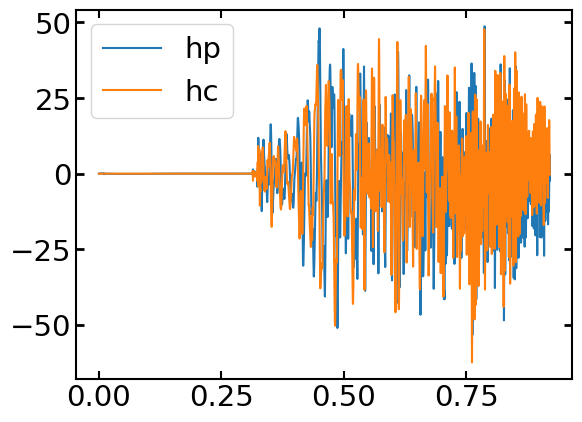

In [129]:
plt.plot(t,hp,label='hp')
plt.plot(t,hc,label='hc')
plt.legend()


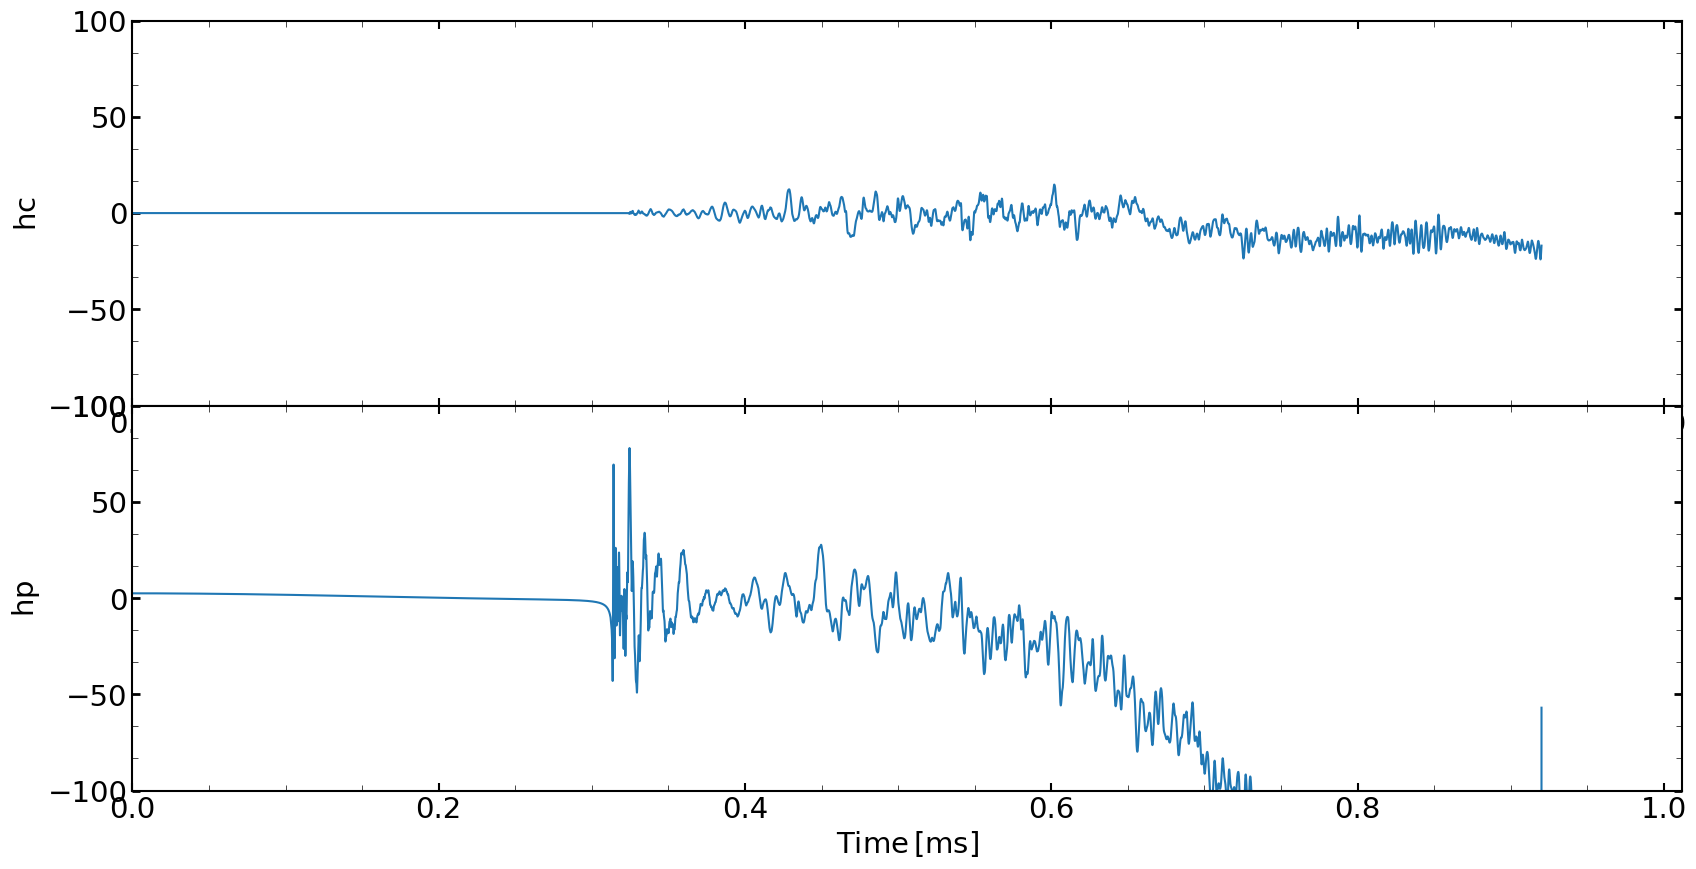

In [121]:
plot_signal(t,hc,hp)

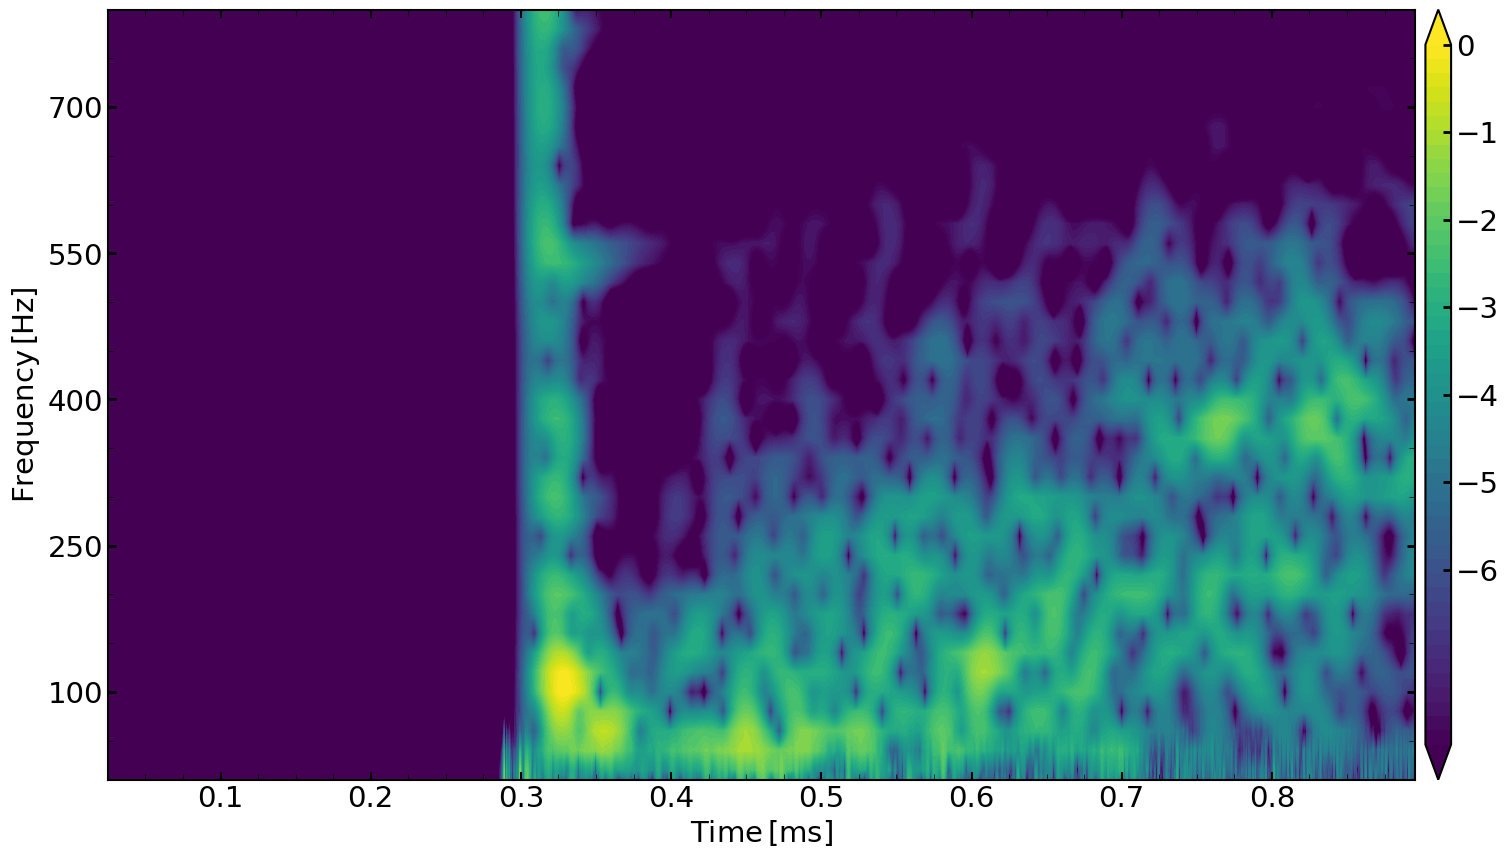

In [125]:
plot_spectrogram(t,hp)

64461467.56501964


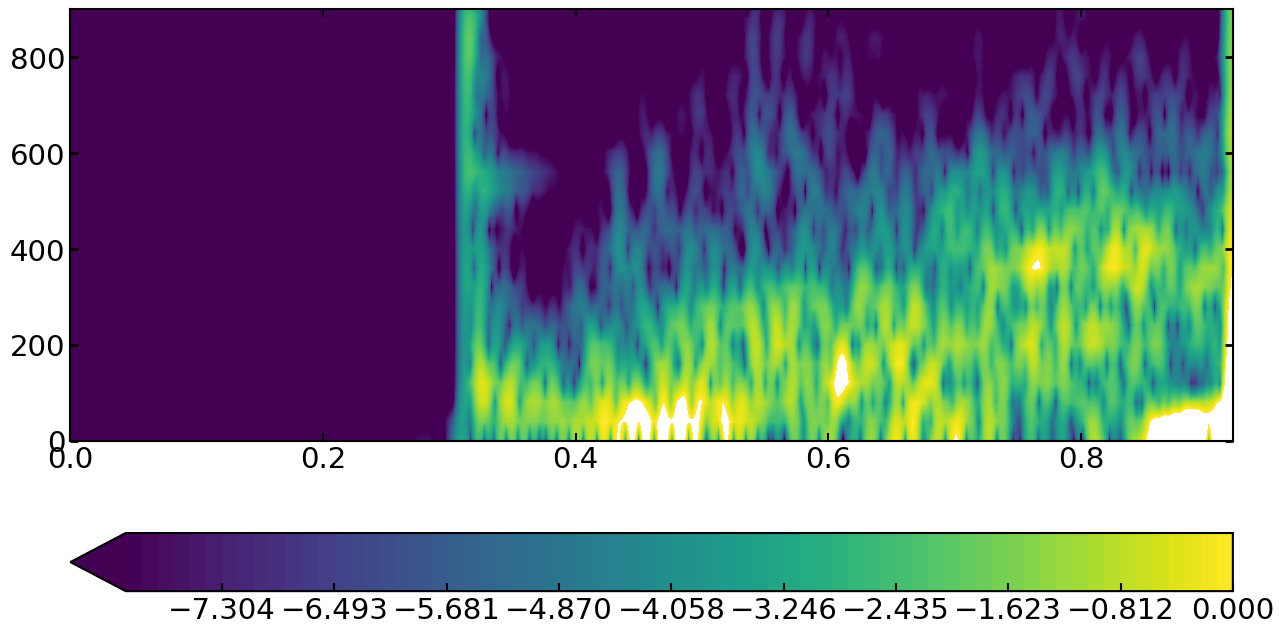

In [115]:
#plot_spectrogram(timecheck,straincheck*prefactor/10)
fiper = interpolate.interp1d(t,hc)

delta_t_mean = np.mean(np.diff(t))
sample_frequency_mean = 1/delta_t_mean

f_list, tau_list, spectrogr = spectrogram(fiper, t, delta_t_mean, sample_frequency_mean,
                                          hann_window=25e-3, overlap_fact=0.95, nfft_fact=1, 
                                          name=None, plot=True, energy=False,
                                         window_name='blackman')